Sampling at 20kHz

Want to accurately capture signals as low as 20Hz

Input Size - 1024 Points



In [22]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow.keras as keras
from keras.legacy import interfaces

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live
import tflite_runtime.interpreter as tflite

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 4)

from sklearn.metrics import confusion_matrix

from scipy.stats import probplot
from scipy.stats import normaltest


from scipy import signal

import os
import pandas as pd
from ML_Train.DBQuerier import DBQuerier as Querier
from sklearn.model_selection import train_test_split
from crawlab_toolbox import plotting as genplt


gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)



%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [55]:
b,a = signal.butter(2, 700, btype='low', analog=False, output='ba', fs=20e3)

In [56]:
dataPoints = 4096
divisor = 4

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]



X_train_healthy = X_train[first_good_train:,:dataPoints]
X_valid_healthy = X_test[first_good_test:,:dataPoints]
X_train_unhealthy = X_train[:first_good_train,:dataPoints]
X_valid_unhealthy = X_test[:first_good_test,:dataPoints]

Y_train_healthy = Y_train[first_good_train:,:]
Y_valid_healthy = Y_test[first_good_test:,:]
Y_train_unhealthy = Y_train[:first_good_train,:]
Y_valid_unhealthy = Y_test[:first_good_test,:]

print(Y_train_unhealthy.shape)

X_train_healthy = X_train_healthy.reshape(X_train_healthy.shape[0] * 4,int(X_train_healthy.shape[1] / 4))
X_valid_healthy = X_valid_healthy.reshape(X_valid_healthy.shape[0] * 4,int(X_valid_healthy.shape[1] / 4))
X_train_unhealthy = X_train_unhealthy.reshape(X_train_unhealthy.shape[0] * 4,int(X_train_unhealthy.shape[1] / 4))
X_valid_unhealthy = X_valid_unhealthy.reshape(X_valid_unhealthy.shape[0] * 4,int(X_valid_unhealthy.shape[1] / 4))

X_train_healthy = signal.lfilter(b, a, X_train_healthy)
X_train_unhealthy = signal.lfilter(b, a, X_train_unhealthy)
X_valid_healthy = signal.lfilter(b, a, X_valid_healthy)
X_valid_unhealthy = signal.lfilter(b, a, X_valid_unhealthy)


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

np.random.shuffle(XY_train)
np.random.shuffle(XY_valid)

X_train = XY_train[:,:-1]
Y_train = XY_train[:,-1]



X_valid = XY_valid[:,:-1]
Y_valid = XY_valid[:,-1]


X_train = (X_train + 2.5) / 5
X_valid = (X_valid + 2.5) / 5

(156, 2)


In [57]:
X_train[0,:]

array([0.5006066 , 0.50131238, 0.49956962, ..., 0.49525082, 0.50465155,
       0.51786772])

In [58]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live, Sampling

def build_classifier(
                   filters, 
                   kernels, 
                   strides,
                   dilation_rates,
                   input_shape,
                   dense_nodes,
                   classes,
                   ):
    inputs = Input(shape=input_shape)
    x = inputs
    
    for i in range(len(filters)):
        x = Conv1D(filters=filters[i], 
                           kernel_size=kernels[i], 
                           strides=strides[i], 
                           activation='relu', 
                           padding='same',
                           dilation_rate=dilation_rates[i])(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    for i in range(len(dense_nodes)):
        x = Dense(dense_nodes[i],activation='relu')(x)
        
    x = Dense(classes,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    return cnn_classifier

def create_classifier(param_dict):
    filters = param_dict["filters"]
    kernels = param_dict["kernels"]
    strides = param_dict["strides"]
    dilation_rates = param_dict["dilation_rates"]
    input_shape = tuple(param_dict["input_shape"])
    dense_nodes = param_dict["dense_nodes"]
    classes = param_dict["classes"]
    
    classifier = build_classifier(filters,kernels,strides,dilation_rates,input_shape,dense_nodes,classes)
 
    return classifier

def build_classifier_from_encoder(param_dict,encoder):
    filters = param_dict["filters"]
    kernels = param_dict["kernels"]
    strides = param_dict["strides"]
    dilation_rates = param_dict["dilation_rates"]
    input_shape = tuple(param_dict["input_shape"])
    dense_nodes = param_dict["dense_nodes"]
    classes = param_dict["classes"]

    inputs = Input(shape=input_shape)
    x = inputs
    
    x = encoder(x)
    x = Flatten()(x)
    
    for i in range(len(dense_nodes)):
        x = Dense(dense_nodes[i],activation='relu')(x)
        
    x = Dense(classes,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    return cnn_classifier

In [59]:
def normalize_scores(scores,log_prob=False):

    flat = np.array([])
    for i in range(len(scores)):
        flat = np.append(flat,scores[i])
    
    max_val = np.amax(flat)
    
    if log_prob:
        scores = [np.log(np.abs(scores[i] - 1.1 * max_val)) for i in range(len(scores))]
    

    norm_mean = np.mean(scores[0])
    norm_std = np.std(scores[0])
    
    scores = [(scores[i] - norm_mean) / norm_std for i in range(len(scores))]
    
    [print(normaltest(scores[i])) for i in range(len(scores))]
    [print(np.std(scores[i]), np.mean(scores[i])) for i in range(len(scores))]
    
    return scores

import numpy as np

from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_encoder(
                   filters, 
                   kernels, 
                   strides,
                   dilation_rates,
                   input_shape
                   ):
    
    encoder = Sequential()
    
    for i in range(len(filters)):
        if i == 0:
            encoder.add(Conv1D(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=strides[i], 
                               activation='relu', 
                               padding='same',
                               dilation_rate=dilation_rates[i],
                               input_shape=input_shape))
        else:
            encoder.add(Conv1D(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=strides[i], 
                               activation='relu', 
                               padding='same',
                               dilation_rate=dilation_rates[i]))
#         encoder.add(BatchNormalization())
        encoder.add(Dropout(0.3))
        encoder.add(MaxPooling1D(2))
        
    return encoder

def create_decoder(
                   filters,
                   kernels,
                   strides,
                   dilation_rates,
                   ):
    
    decoder = Sequential()
    
    filters.reverse()
    kernels.reverse()
    strides.reverse()
    dilation_rates.reverse()
    
    decoder.add(UpSampling1D(2))
    
    for i in range(1,len(filters)):
        decoder.add(Conv1D(filters=filters[i], 
                           kernel_size=kernels[i], 
                           strides=strides[i], 
                           activation='relu', 
                           padding='same',
                           dilation_rate=dilation_rates[i]))
#         decoder.add(Dropout(0.5))
        decoder.add(UpSampling1D(2))
    
    #decoder.add(Dropout_Live(0.5))
    decoder.add(Conv1D(1, 3, 1, activation='sigmoid', padding='same'))
    
    return decoder
    
def create_autoencoder(param_dict):
    filters = param_dict["filters"]
    kernels = param_dict["kernels"]
    strides = param_dict["strides"]
    dilation_rates = param_dict["dilation_rates"]
    input_shape = tuple(param_dict["input_shape"])
        
    encoder = create_encoder(filters,kernels,strides,dilation_rates,input_shape)
    decoder = create_decoder(filters,kernels,strides,dilation_rates)
    
    stacked_ae = Sequential([encoder, decoder])

    return stacked_ae,encoder,decoder
    

In [60]:
if os.path.isfile('data/CNN-AE.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('data/CNN-AE.h5')
    print(model.summary())
else:
    filters=[8,8,8]
    kernels = [3,5,7]
    strides=[1,1,1,1,1,1]
    dilation_rates=[1,1,1,1,1,1]
    input_shape = [1024,1]

    param_dict = {
        "filters":filters,
        "kernels":kernels,
        "strides":strides,
        "dilation_rates":dilation_rates,
        "input_shape":input_shape,
    }

    model,encoder,decoder = create_autoencoder(param_dict)

    model.compile(loss='mean_squared_error',optimizer='adam')
    history = model.fit(X_train[...,np.newaxis],X_train[...,np.newaxis],
                        epochs=5,batch_size=16,
#                         validation_split=0.2,
                        verbose=1,
                        validation_data=[X_valid[...,np.newaxis],X_valid[...,np.newaxis]]
                       )
    
    autoencoder = model
    

Train on 1224 samples, validate on 604 samples
Epoch 1/5
1224/1224 [==============================] - 3s 2ms/sample - loss: 0.0022 - val_loss: 0.0020
Epoch 2/5
1224/1224 [==============================] - 1s 872us/sample - loss: 0.0013 - val_loss: 0.0025
Epoch 3/5
1224/1224 [==============================] - 1s 886us/sample - loss: 8.2716e-04 - val_loss: 0.0025
Epoch 4/5
1224/1224 [==============================] - 1s 904us/sample - loss: 6.6634e-04 - val_loss: 0.0018
Epoch 5/5
1224/1224 [==============================] - 1s 891us/sample - loss: 5.7853e-04 - val_loss: 0.0013


In [62]:
train = True
if not train:
# if os.path.isfile('../../Models/MLP-Classifier/Full/CNN-MLP.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('../../Models/MLP-Classifier/Full/CNN-MLP.h5')
    print(model.summary())
else:

    filters=[16,16,16]
    kernels = [3,5,7]
    strides=[1,1,1,1,1,1]
    dilation_rates=[1,1,1,1,1,1]
    input_shape = [1024,1]
    dense_nodes = [512,64]
    codings_size = 2

    param_dict = {
        "filters":filters,
        "kernels":kernels,
        "strides":strides,
        "dilation_rates":dilation_rates,
        "input_shape":input_shape,
        "dense_nodes":dense_nodes,
        "classes":2
    }
    # model,encoder,decoder = create_vae(param_dict)
    # model = create_classifier(param_dict)
    num_classes = 2
    model = build_classifier_from_encoder(param_dict,encoder)
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy'])
    history = model.fit(X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
                        epochs=10,batch_size=8,
#                         validation_split=0.2,
                        verbose=1,
                      validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
                       )
    
    print(model.summary())
    
    model.save('../../Models/MLP-Classifier/Full/CNN-MLP.h5',save_format='tf')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(os.path.join('../../Models/MLP-Classifier/Lite', 'CNN-MLP.tflite',),
     "wb").write(tflite_model)

Y_cnn_valid_pred = model.predict(X_valid[...,np.newaxis])
Y_cnn_train_pred = model.predict(X_train[...,np.newaxis])



Train on 1224 samples, validate on 604 samples
Epoch 1/10
1224/1224 [==============================] - 1s 689us/sample - loss: 0.6664 - accuracy: 0.5817 - val_loss: 0.6866 - val_accuracy: 0.5927
Epoch 2/10
1224/1224 [==============================] - 1s 413us/sample - loss: 0.6122 - accuracy: 0.6528 - val_loss: 0.8384 - val_accuracy: 0.5695
Epoch 3/10
1224/1224 [==============================] - 0s 407us/sample - loss: 0.5259 - accuracy: 0.7296 - val_loss: 0.7909 - val_accuracy: 0.5811
Epoch 4/10
1224/1224 [==============================] - 1s 413us/sample - loss: 0.5214 - accuracy: 0.7263 - val_loss: 0.7352 - val_accuracy: 0.5728
Epoch 5/10
1224/1224 [==============================] - 1s 416us/sample - loss: 0.4459 - accuracy: 0.7974 - val_loss: 0.9429 - val_accuracy: 0.5728
Epoch 6/10
1224/1224 [==============================] - 0s 406us/sample - loss: 0.3703 - accuracy: 0.8317 - val_loss: 0.8636 - val_accuracy: 0.5762
Epoch 7/10
1224/1224 [==============================] - 0s 408us/

In [63]:
model.predict(X_valid[...,np.newaxis])

array([[0.54165316, 0.45834687],
       [0.24008064, 0.75991935],
       [0.01379876, 0.9862012 ],
       ...,
       [0.03617511, 0.9638249 ],
       [0.5836057 , 0.41639426],
       [0.45695907, 0.54304093]], dtype=float32)

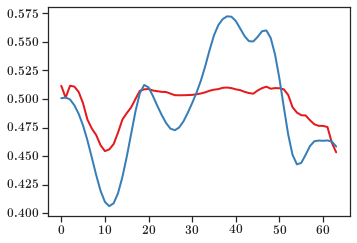

In [64]:
# X_conv_ae.append(np.squeeze(model.predict(X[i][...,np.newaxis])))
# mse_conv_ae.append(keras.metrics.mean_squared_error(X_conv_ae[i],X[i]))

plt.plot(np.squeeze(autoencoder.predict(X_train[0:1,:,np.newaxis]))[:64])
plt.plot(X_train[0:1,:64].T)

In [65]:
Y_cnn_train_pred = np.argmax(Y_cnn_train_pred,axis=1)
Y_cnn_valid_pred = np.argmax(Y_cnn_valid_pred,axis=1)

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

[[ 73 187]
 [ 40 304]]
0.6241721854304636
[[418 206]
 [  0 600]]
0.8316993464052288


No handles with labels found to put in legend.


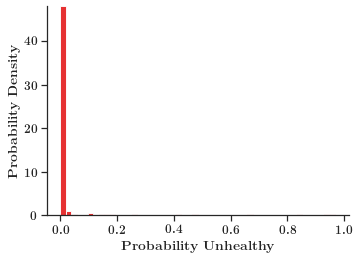

No handles with labels found to put in legend.


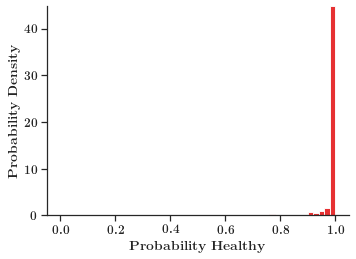

In [26]:
genplt.plot_histogram(model.predict(X_valid_unhealthy[...,np.newaxis])[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'cnn_mlp_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(model.predict(X_valid_healthy[...,np.newaxis])[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'cnn_mlp_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)